In [14]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
# Set some parameters
im_width = 1024
im_height = 1024
border = 5

In [16]:
ids = next(os.walk("images/train"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  627


In [17]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

MemoryError: 

#### Load the images and masks into arrays

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/train/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height))
    # Load masks
    mask = img_to_array(load_img("images/masks/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/root/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5,1,'Numberplate')

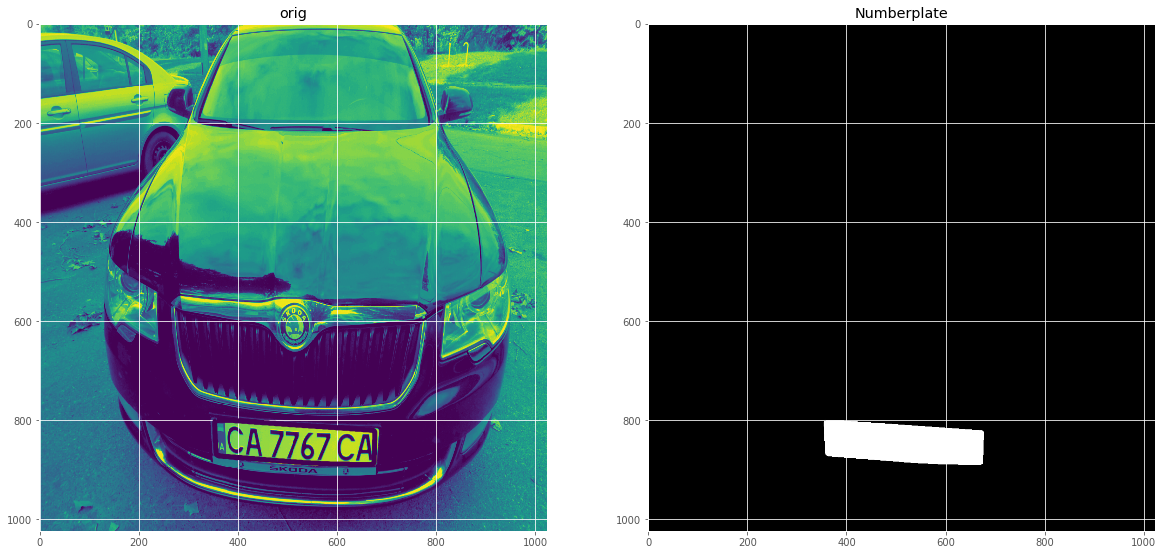

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0])
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), linewidths = 5, levels = [0.5])
ax1.set_title('orig')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray')
ax2.set_title('Numberplate')

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, colors=1):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size, colors),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [9]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, colors=3):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, colors=colors)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, colors=colors)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, colors=colors)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, colors=colors)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, colors=colors)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

W0528 19:14:52.748329 140056083494208 deprecation.py:237] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0528 19:14:53.312857 140056083494208 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0528 19:14:53.483592 140056083494208 deprecation.py:506] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 1 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1024, 1024, 1 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 1024, 1024, 1 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [12]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('tmp_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 564 samples, validate on 63 samples
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[32,1024,1024,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node conv2d_2/BiasAdd}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [ ]:
# load the best model
model.load_weights('tmp_model.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Orig')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Np')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('NP Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('NP Predicted binary');

### Predictions on training set

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
%%time
plot_sample(X_valid, y_valid, preds_val, preds_val_t)